In [57]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import distrax
import haiku as hk
import optax

In [58]:
true_dist = distrax.MixtureOfTwo(0.5,
                                 distrax.Normal(loc=1., scale=0.1),
                                 distrax.Normal(loc=3., scale=0.1)) 

In [59]:
num_bins = 10
rng = jax.random.PRNGKey(1234)
num_layers = 4
range_min = 0.
range_max = 5.

In [60]:
class RQSpline(hk.Module):

    def __init__(self, num_bins, range_min, range_max, num_layers: int):
        super().__init__()
        self.num_bins = num_bins
        self.range_min = range_min
        self.range_max = range_max
        self.num_layers = num_layers

    def create_flow(self, conditioning):
        layers = []
        for _ in range(self.num_layers):
            params = hk.nets.MLP([8, self.num_bins * 3 + 1], activate_final=False)(conditioning)
            layer = distrax.RationalQuadraticSpline(params, self.range_min, self.range_max)
            layers.append(layer)

        flow = distrax.Inverse(distrax.Chain(layers))
        return flow

    def create_distribution(self, conditioning):
        flow = self.create_flow(conditioning)
        base_distribution = distrax.Independent(
            distrax.Uniform(self.range_min, self.range_max),
            reinterpreted_batch_ndims=0)

        dist = distrax.Transformed(base_distribution, flow)
        return dist

    def forward(self, samples, conditioning):
        flow = self.create_flow(conditioning)
        return flow.forward(samples)
    
    def log_prob(self, samples, conditioning):
        assert conditioning.shape[:-1] == samples.shape[:-1]
        dist = self.create_distribution(conditioning)
        return dist.log_prob(samples)

    def sample(self, conditioning):
        dist = self.create_distribution(conditioning)
        rng = hk.next_rng_key()
        return dist.sample(seed=rng, sample_shape=conditioning.shape[:-1])

In [61]:

@hk.without_apply_rng
@hk.transform
def log_prob_fn(samples, conditioning):
    return hk.vmap(RQSpline(num_bins, range_min, range_max, num_layers).log_prob, split_rng=False)(samples, conditioning)


@hk.transform
def sample_fn(conditioning):
    return hk.vmap(RQSpline(num_bins, range_min, range_max, num_layers).sample, split_rng=True)(conditioning)


@hk.without_apply_rng
@hk.transform
def forward_fn(base_samples, conditioning):
    return hk.vmap(RQSpline(num_bins, range_min, range_max, num_layers).forward, split_rng=False)(base_samples, conditioning)

In [62]:
def loss_fn(params, true_samples, true_conditioning):
    loss = -jnp.mean(log_prob_fn.apply(params, true_samples, true_conditioning))
    return loss

batch_size = 18
dummy_samples = jnp.zeros((batch_size, 1))
dummy_conditioning = jnp.ones_like(dummy_samples)
params = log_prob_fn.init(rng, dummy_samples, dummy_conditioning)
tx = optax.adam(1e-4)
opt_state = tx.init(params)

@jax.jit
def train_step(params, opt_state, true_samples, true_conditioning):
    grads = jax.grad(loss_fn)(params, true_samples, true_conditioning)
    updates, opt_state = tx.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state


for step in range(20000):
    step_rng, rng = jax.random.split(rng)
    true_samples = true_dist.sample(seed=rng, sample_shape=(batch_size, 1))
    true_conditioning = jnp.ones_like(true_samples)
    params, opt_state = train_step(params, opt_state, true_samples, true_conditioning)
    if step % 1000 == 0:
        print("step:", step, "loss:", loss_fn(params, true_samples, true_conditioning))


step: 0 loss: 0.83987796
step: 1000 loss: -0.010293775
step: 2000 loss: 0.0631418
step: 3000 loss: 0.114623055
step: 4000 loss: 0.10028616
step: 5000 loss: -0.33724642
step: 6000 loss: 0.0007782645
step: 7000 loss: -0.17828219
step: 8000 loss: -0.2420404
step: 9000 loss: -0.12564795
step: 10000 loss: -0.2598433
step: 11000 loss: -0.24131542
step: 12000 loss: -0.18035294
step: 13000 loss: -0.114505
step: 14000 loss: -0.39719814
step: 15000 loss: -0.44694176
step: 16000 loss: -0.3849491
step: 17000 loss: -0.24036959
step: 18000 loss: -0.15196933
step: 19000 loss: -0.03739472


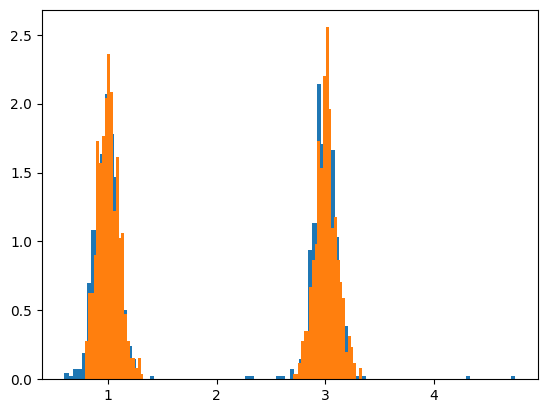

In [65]:
true_samples = true_dist.sample(seed=rng, sample_shape=(1000, 1))
true_conditioning = jnp.ones_like(true_samples)
samples = sample_fn.apply(params, rng, true_conditioning)
plt.hist(samples.flatten(), bins=100, density=True)
plt.hist(true_samples.flatten(), bins=100, density=True)
plt.show()

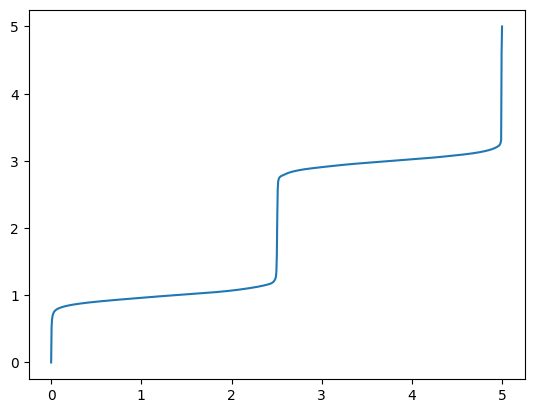

In [72]:
# Visualize flow
x = jnp.linspace(range_min, range_max, 1000)[..., None]
y = forward_fn.apply(params, x, jnp.ones_like(x))
plt.plot(x.flatten(), y.flatten(), label='true');